In [1]:
from google.colab import drive
drive.mount('/content/drive')

import torch
import torch.nn as nn
import numpy as np
import cv2
import matplotlib.pyplot as plt
from torchvision import models, transforms
from PIL import Image
import os


Mounted at /content/drive


In [2]:
cnn = models.resnet18(pretrained=True)

# We want feature maps, so DO NOT remove layers
target_layer = cnn.layer4

device = "cuda" if torch.cuda.is_available() else "cpu"
cnn = cnn.to(device)
cnn.eval()


/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


100%|██████████| 44.7M/44.7M [00:00<00:00, 105MB/s]


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [3]:
transform = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std =[0.229, 0.224, 0.225]
    )
])


In [4]:
IMAGE_DIR = "/content/drive/MyDrive/IIT_Roorkee_Project/images/"

img_name = os.listdir(IMAGE_DIR)[0]   # choose any image
img_path = os.path.join(IMAGE_DIR, img_name)

original_img = Image.open(img_path).convert("RGB")
input_tensor = transform(original_img).unsqueeze(0).to(device)


In [5]:
activations = None
gradients = None

def forward_hook(module, input, output):
    global activations
    activations = output

def backward_hook(module, grad_in, grad_out):
    global gradients
    gradients = grad_out[0]

target_layer.register_forward_hook(forward_hook)
target_layer.register_backward_hook(backward_hook)


In [6]:
output = cnn(input_tensor)

# Dummy scalar for Grad-CAM
score = output.mean()

cnn.zero_grad()
score.backward()


/usr/local/lib/python3.12/dist-packages/torch/nn/modules/module.py:1866: FutureWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  self._maybe_warn_non_full_backward_hook(args, result, grad_fn)


In [7]:
weights = gradients.mean(dim=(2,3), keepdim=True)
cam = (weights * activations).sum(dim=1)
cam = torch.relu(cam)

cam = cam[0].detach().cpu().numpy()
cam = cv2.resize(cam, (224,224))
cam = cam / cam.max()


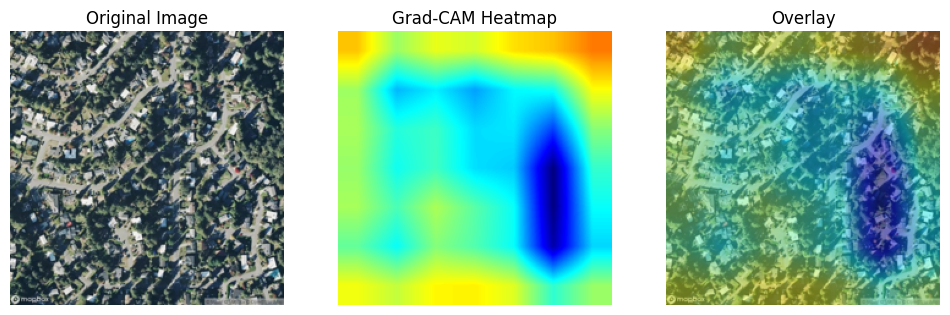

In [8]:
img_np = np.array(original_img.resize((224,224)))

heatmap = cv2.applyColorMap(
    np.uint8(255 * cam),
    cv2.COLORMAP_JET
)

overlay = cv2.addWeighted(img_np, 0.6, heatmap, 0.4, 0)

plt.figure(figsize=(12,4))

plt.subplot(1,3,1)
plt.title("Original Image")
plt.imshow(img_np)
plt.axis("off")

plt.subplot(1,3,2)
plt.title("Grad-CAM Heatmap")
plt.imshow(heatmap)
plt.axis("off")

plt.subplot(1,3,3)
plt.title("Overlay")
plt.imshow(overlay)
plt.axis("off")

plt.show()
